In [236]:
from pyproj import Transformer
import os
from PrettyTable import PrettyTable
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import rasterio
from rasterio import plot

In [237]:
# read raster and convert it to dictionary
def summary_dem(file):
    # dictionary
    summary = ''
    try:
        # read raster
        with rasterio.open(file) as raster:
            # elevationband
            band = raster.read(1)

            # Get the boundary of the raster
            left = raster.bounds.left
            long = raster.bounds.right
            bottom = raster.bounds.bottom
            top = raster.bounds.top

            # Determine raster crs
            if (raster.crs == 'EPSG:4326'):
                # ces transformation
                trans = Transformer.from_crs(raster.crs, 'epsg:3111')
                min_x, min_y = trans.transform(bottom, left)
                max_x, max_y = trans.transform(top, long)
                # write info to dictionary
                summary = {'Filename' : file.split("./")[1],
                           'Coordinate system' : f"{raster.crs}",
                           'Min x, Min Lon' : f"{str(round(min_x,4))} m, {str(round(left,4))} degrees",
                           'Max x, Max Lon' : f"{str(round(max_x,4))} m, {str(round(long,4))} degrees",
                           'Min y, Min Lat' : f"{str(round(min_y,4))} m, {str(round(bottom,4))} degrees",
                           'Max y, Max Lat' : f"{str(round(max_y,4))} m, {str(round(top,4))} degrees",
                           'Width, Height, Cell size' : f"{str(round(raster.width,4))} px {str(round(raster.height,4))} px {str(round(raster.res[0],4))}",
                           'NoData' : str(raster.nodata),
                           'Min value, max value' : f"{str(round(band.min(),4))}, {str(round(band.max(),4))}"}

            elif (raster.crs == 'EPSG:3111'):
                trans = Transformer.from_crs(raster.crs, 'epsg:4326')
                min_y, min_x = trans.transform(bottom, left)
                max_y, max_x = trans.transform(top, long)
                summary = {'Filename' : file.split("./")[1],
                           'Coordinate system' : f"{raster.crs}",
                           'Min x, Min Lon' : f"{str(round(bottom,4))} m, {str(round(min_x,4))} degrees",
                           'Max x, Max Lon' : f"{str(round(top,4))} m, {str(round(max_x,4))} degrees",
                           'Min y, Min Lat' : f"{str(round(left,4))} m, {str(round(min_y,4))} degrees",
                           'Max y, Max Lat' : f"{str(round(long,4))} m, {str(round(max_y,4))} degrees",
                           'Width, Height, Cell size' : f"{str(round(raster.width,4))} px {str(round(raster.height,4))} px {str(round(raster.res[0],4))}",
                           'NoData' : str(raster.nodata),
                           'Min value, max value' : f"{str(round(band.min(),4))},{str(round(band.max(),4))}"}
       
    except FileNotFoundError:
        print("Wrong file or file path")

    return summary

In [238]:
# convert dictionary to lsit and plot it as PrettyTable
def display_summary(dict_summary):
    # table for outputting PrettyTable
    table = [[]]
    keylist = []
    valuelist = []

    for key in dict_summary.keys():
        keylist.append(key)
    for value in dict_summary.values():
        valuelist.append(value)

    table[0] = ['', '']
    for i, row in enumerate(keylist):
        table_ = [row, valuelist[i]]
        table.append(table_)

    new_table = PrettyTable(table, ['', ''])
    print(new_table._repr_latex_())

In [239]:
# Visualize the raster as a plot
def visualization(raster_path):
    try:
        # read raster
        with rasterio.open(raster_path, "r") as src:
            # elevationband
            band = src.read(1)
            # get the leftest and bottomest coordinate
            x_unit = abs(src.bounds.right-src.bounds.left) / len(band[0])
            y_unit = abs(src.bounds.top-src.bounds.bottom) / len(band)
            # convert raster elevation band to numpy array
            # and find the coordinate with the max value
            arr = np.array(band)
            result = np.argwhere(arr == band.max())
            for i, v in enumerate(result):
                print((src.bounds.left + v[1] * x_unit),
                      (src.bounds.top - v[0] * y_unit))

            # prepare the ax for x axis label and y axis label
            fig, ax = plt.subplots()

            # set the value and corresponding color in color bar
            levels = [70.18749, 175, 350, 700, 1400, 1500, 1563.1005]
            clrs = ['#3CFAFF', '#6A95FF', '#E61AFE8C',
                    '#f4ded9', '#eda14f', '#b55400', '#633b11']

            # set cmap as color bar
            cmap, norm = mpl.colors.from_levels_and_colors(levels,
                                                           clrs,
                                                           extend='max')
            # render a plot with color bar
            img = ax.imshow(band, cmap=cmap)
            fig.colorbar(img, spacing='proportional')

            # cover the plot with the the corrdinate map
            img = plot.show((src, 1), cmap=cmap, interpolation='none', ax=ax)
            # set xand y axis label
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

    except FileNotFoundError:
        print("Wrong file or file path")

In [240]:
# resample and reproject the raster
def dataset_conversion(value, output_name):
    summary = ''
    try:
        with rasterio.open(os.path.join(os.path.curdir, "CLIP.tif")) as src:
            # get input coordinate system
            Input_CRS = src.crs
            # define the output coordinate system
            Output_CRS = "EPSG:3111"
            # set up the transform and essential arguments
            Affine, Width, Height = calculate_default_transform(Input_CRS,
                                                                Output_CRS,
                                                                src.width * value,
                                                                src.height * value,
                                                                *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': Output_CRS,
                           'transform': Affine,
                           'affine': Affine,
                           'width': Width,
                           'height': Height})

            # create and write the transformation(resampling 
            # and reprojection) info to the new tif file
            with rasterio.open(os.path.join(os.path.curdir,
                                            output_name + '.tif'),
                               'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(source=rasterio.band(src, i),
                              destination=rasterio.band(dst, i),
                              src_transform=src.transform,
                              src_crs=src.crs,
                              dst_transform=Affine,
                              dst_crs=Output_CRS,
                              dst_nodata=0,
                              resampling=Resampling.bilinear)

        # render a plot with the new crs and coaser version
        with rasterio.open(os.path.join(os.path.curdir,
                                        output_name + '.tif')) as dataset_:
            fig, ax = plt.subplots(1, 1)
            plot.show_hist(dataset_.read(1),
                           bins=200,
                           histtype='stepfilled',
                           title=output_name,
                           ax=ax)
            # set xand y axis label
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')

        # retuen raster to plot the PrettyTable
        summary = summary_dem(os.path.join(os.path.curdir,
                                           output_name + '.tif'))

    except FileNotFoundError:
        print("Wrong file or file path")

    return summary

In [241]:
def gaussianFilter(sizex, sizey=None, scale=0.333):
    '''
    Generate and return a 2D Gaussian function
    of dimensions (sizex,sizey)
    If sizey is not set, it defaults to sizex
    A scale can be defined to widen the function (default = 0.333)
    '''
    sizey = sizey or sizex
    x, y = np.mgrid[-sizex:sizex + 1, -sizey:sizey + 1]
    g = np.exp(-scale * (x**2 / float(sizex) + y**2 / float(sizey)))
    return g / g.sum()

In [242]:
def grad2d(dem, cell_size):
    '''
    Calculate the slope and gradient of a DEM
    '''
    f0 = gaussianFilter(3)
    # applies smooothing by gaussian filter
    i = signal.convolve(dem, f0, mode='valid')
    # SOBEL FILTER
    f1 = np.array([[0, 0, 0], [1, 0, -1], [0, 0, 0]])
    f2 = f1.transpose()
    g1 = signal.convolve(i, f1, mode='valid') / (cell_size * 2)
    g2 = signal.convolve(i, f2, mode='valid') / (cell_size * 2)
    slope = np.sqrt(g1**2 + g2**2)
    aspect = np.arctan(slope)
    return slope, aspect

In [243]:
# 2FD Algorithms
def slope_calculation_2FD(raster_path):
    with rasterio.open(raster_path, 'r+') as src:
        data = src.read()[0]
        # 2FD algorithms
        slope, aspect = grad2d(data, src.res[0])

        slope_degree = np.full(slope.shape, 1)
        for i in range(0, len(slope)):
            for j in range(0, len(slope[0])):
                # Convert value to slope (degree)
                slope_degree[i][j] = abs(math.atan(slope[i][j])
                                         * 180 / math.pi)

        result = np.array(slope_degree).flatten()
        return result

In [244]:
# Maximum Max Algorithms
def slope_calculation_MAX(raster_path):
    with rasterio.open(raster_path, 'r+') as src:
        data = src.read()[0]
        slope_degree = np.full(data.shape, 1)
        mf = math.sqrt(2) * src.res[0]
        cs = src.res[0]

        for i in range(1, data.shape[0] - 1):
            for j in range(1, data.shape[1] - 1):
                # maximum max value algorithms
                slope = max((data[i, j + 1] - data[i, j]) / cs,
                            (data[i + 1, j] - data[i, j]) / cs,
                            (data[i, j - 1] - data[i, j]) / cs,
                            (data[i - 1, j] - data[i, j]) / cs,
                            (data[i + 1, j + 1] - data[i, j]) / mf,
                            (data[i + 1, j - 1] - data[i, j]) / mf,
                            (data[i - 1, j + 1] - data[i, j]) / mf,
                            (data[i - 1, j - 1] - data[i, j]) / mf)

                # Convert value to slope (degree)
                slope_degree[i, j] = abs(math.atan(slope) * 180 / math.pi)

        result = np.array(slope_degree).flatten()
        return result

The following content provides the answers and solutions for the questions in the third assessment of GEOM90042 course 

# Introduction
This section is to read the GeoTIFF data and output the following dictionary in order to impliment further geoprocesses

In [ ]:
dict_summary = summary_dem(os.path.join(os.path.curdir,"CLIP.tif"))
display_summary(dict_summary)

\begin{longtable}[c]{@{}ll@{}}
Parameter & Value\\\addlinespace
\midrule\endhead
 & \\\addlinespace 
Filename & CLIP.tif\\\addlinespace 
Coordinate system & EPSG:4326\\\addlinespace 
Min x, Min Lon & 2539962.6884 m, 145.4549 degrees\\\addlinespace 
Max x, Max Lon & 2627972.3349 m, 146.4463 degrees\\\addlinespace 
Min y, Min Lat & 2391287.389 m, -37.9788 degrees\\\addlinespace 
Max y, Max Lat & 2450557.3726 m, -37.4368 degrees\\\addlinespace 
Width, Height, Cell size & 3569 px 1951 px 0.0003\\\addlinespace 
NoData & -3.4028234663852886e+38\\\addlinespace 
Min value, max value & 70.1875, 1563.1005\\\addlinespace 
\end{longtable}

Then, the following coordinate and image separately present the highest value of the GeoTIFF and the ordinal map. 
The map with WGS84 coordinate system shows the ranking of the value. THe highest value is labeded as brown color. The lowest value is labeled as light blue color.  

146.29430555608195 -37.83125000025668


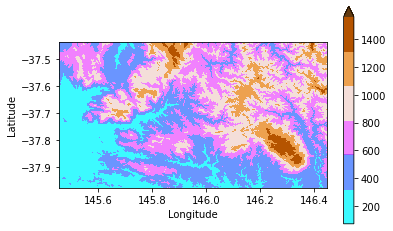

In [246]:
visualization(os.path.join(os.path.curdir,"CLIP.tif"))

# Motivation
The report is to discuss the comparasion of the methodologies in focal operation.
In this sestion, it will convert the dataset of GeoTIFF used in previous to a projected coordinate system (epsg:3111) so that it can perfectly fit in the Victoria state in Australia. in addition, it will provides two coarser versions of dataset with 2x and 4x the cells size implimented by bilinear interpolation. The outputs will be two versions histograms and tables.

## 2x Coaser version histogram and table

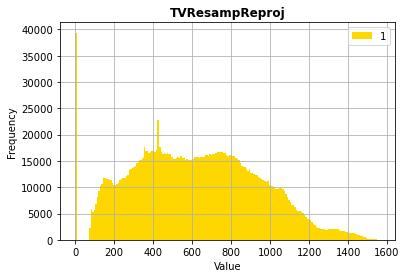

In [247]:
_2x_summary = dataset_conversion(0.5, "TVResampReproj")

In [ ]:
display_summary(_2x_summary)

\begin{longtable}[c]{@{}ll@{}}
Parameter & Value\\\addlinespace
\midrule\endhead
 & \\\addlinespace 
Filename & TVResampReproj.tif\\\addlinespace 
Coordinate system & EPSG:3111\\\addlinespace 
Min x, Min Lon & 2390443.6352 m, 143.7749 degrees\\\addlinespace 
Max x, Max Lon & 2451433.2929 m, 144.4624 degrees\\\addlinespace 
Min y, Min Lat & 2539962.8357 m, -36.6335 degrees\\\addlinespace 
Max y, Max Lat & 2627925.6783 m, -35.8458 degrees\\\addlinespace 
Width, Height, Cell size & 1686 px 1169 px 52.1725\\\addlinespace 
NoData & -3.4028234663852886e+38\\\addlinespace 
Min value, max value & 0.0, 1561.6875\\\addlinespace 
\end{longtable}

## 4x Coaser version histogram and table

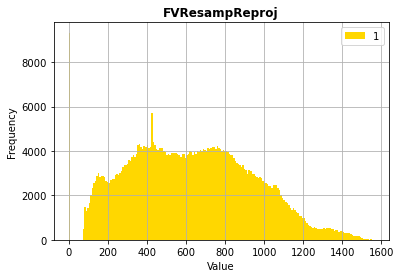

In [228]:
_4x_summary = dataset_conversion(0.25, "FVResampReproj")

In [ ]:
display_summary(_4x_summary)

\begin{longtable}[c]{@{}ll@{}}
Parameter & Value\\\addlinespace
\midrule\endhead
 & \\\addlinespace 
Filename & FVResampReproj.tif\\\addlinespace 
Coordinate system & EPSG:3111\\\addlinespace 
Min x, Min Lon & 2390501.3589 m, 143.7755 degrees\\\addlinespace 
Max x, Max Lon & 2451433.2929 m, 144.4624 degrees\\\addlinespace 
Min y, Min Lat & 2539963.1303 m, -36.6335 degrees\\\addlinespace 
Max y, Max Lat & 2627917.9598 m, -35.8459 degrees\\\addlinespace 
Width, Height, Cell size & 843 px 584 px 104.3355\\\addlinespace 
NoData & -3.4028234663852886e+38\\\addlinespace 
Min value, max value & 0.0, 1558.3864\\\addlinespace 
\end{longtable}

# Implementation

This section is to discuss the comparison of the method use for analyzing slope distribiution in the area of Victoria state by implimentating 2FD and maximum value algorithms. Moreover, it will look at the diversity of methodolohies as well as the geographical relation of the area. To be more specifically, it will use the two coaser versions GeoTIFF with reprojected CRS (EPSG:311) to output two histotrams that each plot is generated from two methods' output.  

Regarding the 2FD and maximum max value methodologies, the report refers to following research paper:

\begin{longtable}[c]{@{}ll@{}}
\toprule\addlinespace
title & Estimating slope from raster data: a test of eight different algorithms in flat, undulating and steep terrain\\\addlinespace 
journal & River Basin Management VI\\\addlinespace 
year & 2011\\\addlinespace 
pages & 143 - 154\\\addlinespace 
doi & 10.2495/RM110131\\\addlinespace 
volume & 146\\\addlinespace 
\bottomrule
\end{longtable}

## 2FD Algorithms

This implimentation extends the original 2FD filter matrix to the following:

\begin{gather}
 2FDFilter
 =
  \begin{bmatrix}
   0 & 0 & 0 \\
   1 & 0 & -1 \\ 
   0 & 0 & 0
   \end{bmatrix}
\end{gather}



## Maximum max algorithms

A 3×3 window with numbered cells. 
\begin{eqnarray}
9, 8, 7, \nonumber\\
6, 5, 4, \nonumber\\
3, 2, 1, \nonumber
\end{eqnarray}
\
\begin{equation}
MaximumMaxValue = max((abs(z5-z1)/\sqrt{2}CellSize), \nonumber\\
(abs(z5-z2)/CellSize), \nonumber\\
(abs(z5-z3)/\sqrt{2}CellSize)), \nonumber\\
(abs(z5-z9)/\sqrt{2}CellSize)), \nonumber\\
(abs(z5-z7)/\sqrt{2}CellSize)), \nonumber\\
(abs(z5-z6)/CellSize)), \nonumber\\
(abs(z5-z8)/CellSize)), \nonumber\\
(abs(z5-z4)/CellSize)) \nonumber
\end{equation}


## Value to slope

For the purposes of this process, considering to analysis of slope distribution, this report will conver the value generated from 2FD and maximum max value algorithms to slope degree. The following is the slope conversion equation:

\begin{equation}
slope = atan(value)180/\pi
\end{equation}


# Results
The following two outputs separately are slope distribution analysis 2x coarser version GeoTIFF and 4x coarser version GeoTIFF. Both processes applies 2FD and maximum max value algorithms

In [252]:
_4x_2fd = slope_calculation_2FD(os.path.join(os.path.curdir, "FVResampReproj.tif"))

In [251]:
_2x_2fd = slope_calculation_2FD(os.path.join(os.path.curdir, "TVResampReproj.tif"))

In [253]:
_4x_max = slope_calculation_MAX(os.path.join(os.path.curdir, "FVResampReproj.tif"))

In [254]:
_2x_max = slope_calculation_MAX(os.path.join(os.path.curdir, "TVResampReproj.tif"))

## 2x Slope Distribution Analysis with 2FD and Maximum Max Value Algorithms

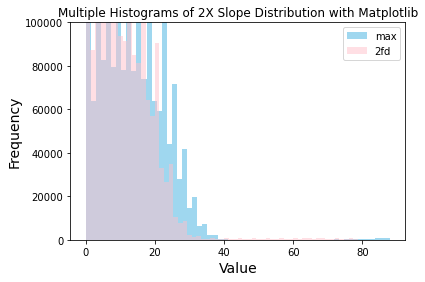

In [255]:
plt.hist(_2x_max, bins = 60, rwidth = 10, color = "skyblue" ,alpha = 0.8, label = "max")
plt.hist(_2x_2fd, bins = 60, rwidth = 10, color = "pink" ,alpha = 0.5, label = "2fd")
plt.ylim(0, 100000)
plt.xlabel("Value", size = 14)
plt.ylabel("Frequency", size = 14)
plt.title("Multiple Histograms of 2X Slope Distribution with Matplotlib")
plt.legend(loc = 'upper right')

## 4x Slope Distribution Analysis with 2FD and Maximum Max Value Algorithms

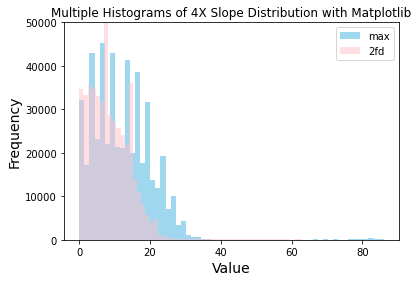

In [256]:
plt.hist(_4x_max, bins = 60, rwidth = 10, color = "skyblue" ,alpha = 0.8, label = "max")
plt.hist(_4x_2fd, bins = 60, rwidth = 10, color = "pink" ,alpha = 0.5, label = "2fd")
plt.ylim(0, 50000)
plt.xlabel("Value", size = 14)
plt.ylabel("Frequency", size = 14)
plt.title("Multiple Histograms of 4X Slope Distribution with Matplotlib")
plt.legend(loc = 'upper right')

# Conclusions

The two results outputted above presents two methods generate overall similar slope distribution and tendency. The slope value gererally distributes around 10 degree.
However, in several processes of focal operation, the maximum max algorithms may bring higer frequency of specific value compared with 2FD algorithms. The reason causing this situation maybe maximum max operation extract the maximum valae per nine cells so that the most common slope value shows higher frequency.  

# References
[1] J Tang and P Pilesj ̈o. Estimating slope from raster data: a test of eight different algorithms in flat, undulating and steep terrain, 2011.